## MGRIT + HiTS

### Created by Cody Balos

Based on multiscale HiTS by Yuying Liu.

This script is a template for benchmarking MGRIT+HiTS against single time-scale neural network time-steppers.

In [1]:
import os
import sys
import time
import torch
import numpy as np
import scipy.interpolate
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

module_path = os.path.abspath(os.path.join('../../src/'))
if module_path not in sys.path:
    sys.path.append(module_path)

module_path = os.path.abspath(os.path.join('../../examples/'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import ResNet as net

In [2]:
# adjustables
dt = 0.01                     # time unit: 0.0005 for Lorenz and 0.01 for others
system = 'LinearAdvection-dt1e-2'         # system name: 'Hyperbolic', 'Cubic', 'VanDerPol', 'Hopf' or 'Lorenz'

In [3]:
# path
data_dir = os.path.join('../../../data/', system)
model_dir = os.path.join('../../../models/', system)

# global const
ks = list(range(7))
step_sizes = [2**k for k in ks]

### load data & models

In [4]:
# load validation set and test set
val_data = np.load(os.path.join(data_dir, 'val_noise0.0.npy'))
test_data = np.load(os.path.join(data_dir, 'test_noise0.0.npy'))

In [5]:
# load models
models = list()
for step_size in step_sizes:
    print('load model_D{}.pt'.format(step_size))
    model = torch.load(os.path.join(model_dir, 'model_D{}_noise0.0.pt'.format(step_size)), map_location='cpu').to('cpu')
    models.append(model)

# fix model consistencies trained on gpus (optional)
for model in models:
    model.device = 'cpu'
    model._modules['increment']._modules['activation'] = torch.nn.ReLU()

load model_D1.pt
load model_D2.pt
load model_D4.pt
load model_D8.pt
load model_D16.pt
load model_D32.pt
load model_D64.pt


### benchmarks

In [6]:
# shared info
n_steps = test_data.shape[1] - 1
nx = test_data.shape[2]
t = [dt*(step+1) for step in range(n_steps)]
criterion = torch.nn.MSELoss(reduction='none')

  0%|          | 0/7 [00:00<?, ?it/s]

/home/cbalos/Workspace/amath590/multiscale_HiTS/src/ResNet.py:102: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  preds.insert(0, torch.tensor(x_init).float().to(self.device))
/home/cbalos/anaconda3/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:623: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/cbalos/anaconda3/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:626: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


(array([-10.,  -8.,  -6.,  -4.,  -2.,   0.,   2.,   4.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

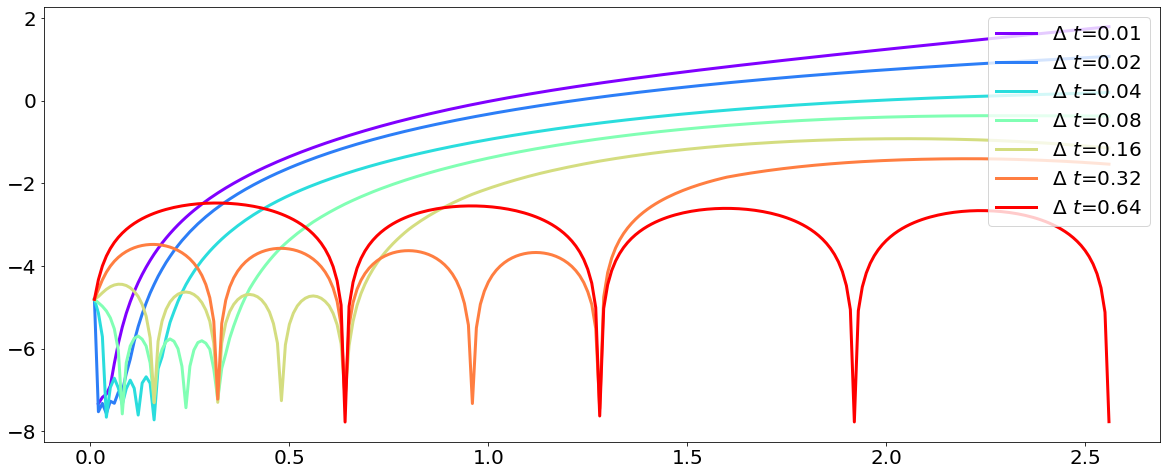

In [7]:
# uniscale time-stepping with NN
preds_mse = list()
times = list()

for model in tqdm(models):
    start = time.time()
    y_preds = model.uni_scale_forecast(
        torch.tensor(test_data[:, 0, :]).float(), n_steps=n_steps
        )
    end = time.time()
    times.append(end - start)
    preds_mse.append(criterion(torch.tensor(test_data[:, 1:, :]).float(), y_preds).mean(-1))
    
# visualize forecasting error at each time step    
fig = plt.figure(figsize=(20, 8))
colors=iter(plt.cm.rainbow(np.linspace(0, 1, len(ks))))
for k in range(len(preds_mse)):
    err = preds_mse[k]
    mean = err.mean(0).detach().numpy()
    rgb = next(colors)
    plt.plot(t, np.log10(mean), linestyle='-', color=rgb, linewidth=3.0, label='$\Delta\ t$={}'.format(step_sizes[k]*dt))
plt.legend(fontsize=20, loc='upper right')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

In [9]:
# cross validation (model selections) 
from pymgrit import Mgrit
from mgrit_hits import VectorHits, MgritHits
from linear_advection import Advection1D

def store_prediction(self, y_preds):
    y_preds.append([self.u[0][i].get_values().numpy() for i in self.index_local[0]])

mgrit_levels = []

start_idx = 0
end_idx = len(models)
best_mse = 1e+5

tf = dt*n_steps

# determine the MSE for each 2-level hirearchy
mse = []
for i in range(len(models)-1, 0, -1):
    y_preds = []
    for j in tqdm(range(val_data.shape[0])):
        y_init = torch.tensor(val_data[j, 0, :]).float()
        problem = Advection1D(c=1, domain=[-1,1], nx=nx+1, u_init=y_init)

        mgrit_levels = [
            MgritHits(model=None, stepfn=problem.step_backward_euler,
                      ic=y_init, t_start=0, t_stop=tf, nt=n_steps+1),
            MgritHits(model=model, ic=y_init, t_start=0, t_stop=tf, nt=n_steps//(2**i)+1)
        ]
        mgrit = Mgrit(problem=mgrit_levels, tol=1e-6, cycle_type='V', max_iter=25,
                      output_fcn=lambda self: store_prediction(self, y_preds),
                      logging_lvl=30)
        mgrit.solve()
    y_preds = np.array(y_preds)

    mse.append(criterion(torch.tensor(val_data[:, 1:, :]).float(), 
                         torch.tensor(y_preds[:,1:,:]).float()).mean().item())
    print(f'mse: {mse[-1]}')


  0%|          | 0/128 [00:00<?, ?it/s]

mse: 6.225216202437878e-05


  0%|          | 0/128 [00:00<?, ?it/s]

mse: 6.225216202437878e-05


  0%|          | 0/128 [00:00<?, ?it/s]

mse: 6.225216202437878e-05


  0%|          | 0/128 [00:00<?, ?it/s]

mse: 6.22524821665138e-05


  0%|          | 0/128 [00:00<?, ?it/s]

mse: 1008095.875


  0%|          | 0/128 [00:00<?, ?it/s]

mse: 1.9299115605384015e+22
use models 0 - 7.


In [10]:
# if mse <= best_mse:
#     start_index = len(models)-i
#     best_mse = mse

# # choose the coarsest (largest time step) model 
# for i in tqdm(range(end_idx)):
#     y_preds = net.vectorized_multi_scale_forecast(torch.tensor(val_data[:, 0, :]).float(), n_steps=n_steps, models=models[i:end_idx])
#     mse = criterion(torch.tensor(val_data[:, 1:, :]).float(), y_preds).mean().item()
#     if mse <= best_mse:
#         end_index = i
#         best_mse = mse
        
# print('use models {} - {}.'.format(start_idx, end_idx))
# models = models[start_idx:end_idx]

[6.225216202437878e-05, 6.225216202437878e-05, 6.225216202437878e-05, 6.22524821665138e-05, 1008095.875, 1.9299115605384015e+22]
